# The BESS optimisation problem

The optimisation problem formulated here largely stems from the work laid out in [1] and [2]. Given a price forecast over a rolling horizon, the model optimally allocates charging and discharging of the battery across each interval.

## Sets and indices

| Symbol | Description |
|--------|-------------|
| $t \in \{1, \ldots, N\}$ | Discrete time steps over the optimisation horizon |
| $N$ | Number of intervals in the horizon |

## Parameters

| Symbol | Description |
|--------|-------------|
| $\Delta t$ | Duration of each interval (hours); $\Delta t = \tfrac{5}{60}$ |
| $\lambda^{(t)}$ | Electricity price forecast at time $t$ (\$/MWh) |
| $c^{(0)}$ | Initial state of charge (MWh) |
| $C_{\max}$ | Maximum energy capacity (MWh) |
| $P_{\max}$ | Maximum charge/discharge power (MW) |
| $\eta_{ch}$ | Round-trip charging efficiency |
| $\eta_{dch}$ | Round-trip discharging efficiency |
| $\gamma$ | Cycling penalty coefficient (\$/MW), discourages frequent switching |

## Decision variables

| Symbol | Description |
|--------|-------------|
| $p_{ch}^{(t)} \geq 0$ | Charging power at interval $t$ (MW) |
| $p_{dch}^{(t)} \geq 0$ | Discharging power at interval $t$ (MW) |

## Formulation

$$
\min_{p_{ch},\, p_{dch}} \quad \Delta t \sum_{t=1}^{N} \left[ \lambda^{(t)}\!\left( p_{ch}^{(t)} - p_{dch}^{(t)} \right) + \gamma \left( p_{ch}^{(t)} + p_{dch}^{(t)} \right) \right] \tag{1}
$$

subject to:

$$
c^{(t)} = c^{(0)} + \Delta t \sum_{n=1}^{t} \left( \eta_{ch}\, p_{ch}^{(n)} - \eta_{dch}\, p_{dch}^{(n)} \right), \qquad \forall\, t \tag{2}
$$

$$
0 \leq c^{(t)} \leq C_{\max}, \qquad \forall\, t \tag{3}
$$

$$
0 \leq p_{ch}^{(t)} \leq P_{\max}, \qquad \forall\, t \tag{4}
$$

$$
0 \leq p_{dch}^{(t)} \leq P_{\max}, \qquad \forall\, t \tag{5}
$$

The objective (1) minimises the net cost of energy traded: paying $\lambda^{(t)}$ per MWh when charging and earning $\lambda^{(t)}$ per MWh when discharging, with a cycling penalty $\gamma$ that discourages unnecessarily frequent charge/discharge switching. Constraint (2) tracks the state of charge via a running cumulative sum. Constraints (3)–(5) enforce energy and power limits.

This is a convex LP, and interestingly enough no binary variables are required. I thought this would not be the case when it came to enforcing mutually-exclusive charging and discharging, but non-simultaneous charging and discharging is guaranteed implicitly by the structure of the problem when $\eta_{ch} \neq \eta_{dch}$ (a requirement I've enforced at runtime). This is something Claude helped me figure out, and is still a premise I'm coming to terms with. Regardless, it seems to hold in practice.

Below is the CVXPY implementation of this,


In [1]:
import cvxpy as cp

dt = 5 / 60  # 5 minutes out of hours
horizon = 12 * 24  # The number of 5-minute intervals in 24 hours
gamma = 20  # Cost per MW of charging/discharging, higher values discourage frequent cycling

forecast = cp.Parameter(horizon, name="forecast")
c_initial = cp.Parameter(name="c_initial")
p_max = cp.Parameter(name="p_max")
c_max = cp.Parameter(name="c_max")
eta_chg = cp.Parameter(name="eta_chg")
eta_dchg = cp.Parameter(name="eta_dchg")

p_charge = cp.Variable(horizon, nonneg=True, name="p_charge")
p_discharge = cp.Variable(horizon, nonneg=True, name="p_discharge")

objective = cp.Minimize(
    dt
    * cp.sum(
        cp.multiply(forecast, p_charge - p_discharge)
        + gamma * (p_charge + p_discharge)
    )
)

c_soc = c_initial + dt * cp.cumsum(p_charge * eta_chg - p_discharge * eta_dchg)

constraints = [
    c_soc >= 0,
    c_soc <= c_max,
    p_charge <= p_max,
    p_discharge <= p_max,
]

problem = cp.Problem(objective=objective, constraints=constraints)

We can pull some data to demonstrate this in practice.

In [2]:
import pandas

from bessie.backtests import BacktestInputData
from bessie.core import Region
from bessie.plotting import tsplot


start = pandas.Timestamp("2022-01-01 00:00:00")
end = pandas.Timestamp("2022-02-01 00:00:00")

data = BacktestInputData.from_aemo_forecasts(
    start=start,
    end=end,
    region=Region.NSW,
)

problem.param_dict["forecast"].value = data.forecast[0, :horizon]
problem.param_dict["c_initial"].value = 0
problem.param_dict["p_max"].value = 50  # A 50 MW power rating
problem.param_dict["c_max"].value = 50  # A 50 MWh energy capacity
problem.param_dict["eta_chg"].value = 0.9  # A 90% charging efficiency
problem.param_dict["eta_dchg"].value = 0.95  # A 95% discharging efficiency

problem.solve(solver=cp.CLARABEL, verbose=True)

2026-02-19 14:43:53,491 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_predispatch/_get_predispatch_price_single/year=2022month=1.netcdf
2026-02-19 14:43:53,682 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_predispatch/_get_predispatch_price_single/year=2022month=2.netcdf
2026-02-19 14:43:53,700 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_p5min/_get_p5min_price_single/year=2022month=1.netcdf
2026-02-19 14:43:53,707 - INFO - root - Loading cached file: /data/xarray_cache/bessie/data/bronze/_p5min/_get_p5min_price_single/year=2022month=2.netcdf
2026-02-19 14:43:53,721 - INFO - root - nemosis query start: 2022/01/01 00:00:00
2026-02-19 14:43:53,721 - INFO - root - nemosis query end: 2022/02/01 00:00:00
2026-02-19 14:43:53,722 - INFO - nemosis.data_fetch_methods - Compiling data for table DISPATCHPRICE
2026-02-19 14:43:54,001 - INFO - nemosis.data_fetch_methods - Returning DISPATCHPRICE.


(CVXPY) Feb 19 02:43:54 PM: Your problem has 576 variables, 1152 constraints, and 293 parameters.
(CVXPY) Feb 19 02:43:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 19 02:43:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 19 02:43:54 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 19 02:43:54 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Feb 19 02:43:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Feb 19 02:43:54 PM: Applying reduction Dcp2Cone
(CVXPY) Feb 19 02:43:54 PM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 19 02:43:54 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 19 02:43:54 PM: Applying reduction CLARABEL
(CVXPY) Feb 19 02:43:54 PM: Finished problem compilation (took 3.590e-02 seconds).
(CVXPY) Feb 19 02:43:54 PM: (Subsequent compilations of this problem, using the same arguments, s

                                     CVXPY                                     
                                     v1.8.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------
           Clarabel.rs v0.11.1  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 1152
  constraint

(CVXPY) Feb 19 02:43:54 PM: Problem status: optimal
(CVXPY) Feb 19 02:43:54 PM: Optimal value: -7.296e+03
(CVXPY) Feb 19 02:43:54 PM: Compilation took 3.590e-02 seconds
(CVXPY) Feb 19 02:43:54 PM: Solver (including time spent in interface) took 1.511e-02 seconds


  0  +3.0621e+04  -1.0388e+06  3.49e+01  3.04e-01  1.45e-02  1.00e+00  1.18e+03   ------   
  1  +1.4904e+04  -3.6306e+05  2.54e+01  1.34e-01  5.29e-03  2.31e+02  4.99e+02  8.12e-01  
  2  +8.4082e+03  -7.6885e+04  1.01e+01  3.32e-02  1.34e-03  5.95e+01  1.46e+02  7.43e-01  
  3  +9.9614e+01  -2.8250e+04  2.85e+02  1.08e-02  4.44e-04  2.07e+01  5.17e+01  7.00e-01  
  4  -1.9093e+03  -2.1930e+04  1.05e+01  7.25e-03  2.96e-04  1.44e+01  3.67e+01  5.45e-01  
  5  -4.7283e+03  -1.2945e+04  1.74e+00  2.75e-03  1.11e-04  5.92e+00  1.53e+01  6.01e-01  
  6  -5.9889e+03  -1.0193e+04  7.02e-01  1.33e-03  5.32e-05  2.85e+00  7.84e+00  8.50e-01  
  7  -6.7949e+03  -8.4235e+03  2.40e-01  4.99e-04  2.00e-05  1.10e+00  3.05e+00  6.24e-01  
  8  -7.0030e+03  -7.8060e+03  1.15e-01  2.43e-04  9.72e-06  5.31e-01  1.50e+00  8.08e-01  
  9  -7.0924e+03  -7.6415e+03  7.74e-02  1.65e-04  6.59e-06  3.58e-01  1.03e+00  8.11e-01  
 10  -7.2554e+03  -7.3634e+03  1.49e-02  3.21e-05  1.28e-06  7.04e-02  2.02e-01 

np.float64(-7296.028873115682)

2026-02-19 14:43:54,205 - INFO - choreographer.browsers.chromium - Chromium init'ed with kwargs {}
2026-02-19 14:43:54,205 - INFO - choreographer.browsers.chromium - Found chromium path: /app/.venv/lib/python3.12/site-packages/choreographer/cli/browser_exe/chrome-linux64/chrome
2026-02-19 14:43:54,206 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmpzdl2swkp.
2026-02-19 14:43:54,207 - INFO - choreographer.browser_async - Opening browser.
2026-02-19 14:43:54,207 - INFO - choreographer.utils._tmpfile - Temp directory created: /tmp/tmpvekwby8q.
2026-02-19 14:43:54,220 - INFO - choreographer.browsers.chromium - Temporary directory at: /tmp/tmpvekwby8q
2026-02-19 14:43:54,469 - INFO - kaleido.kaleido - Conforming 1 to file:///tmp/tmpzdl2swkp/index.html
2026-02-19 14:43:54,470 - INFO - kaleido.kaleido - Waiting on all navigates
2026-02-19 14:43:55,771 - INFO - kaleido.kaleido - All navigates done, putting them all in queue.
2026-02-19 14:43:55,774 - INFO - kaleido.kale

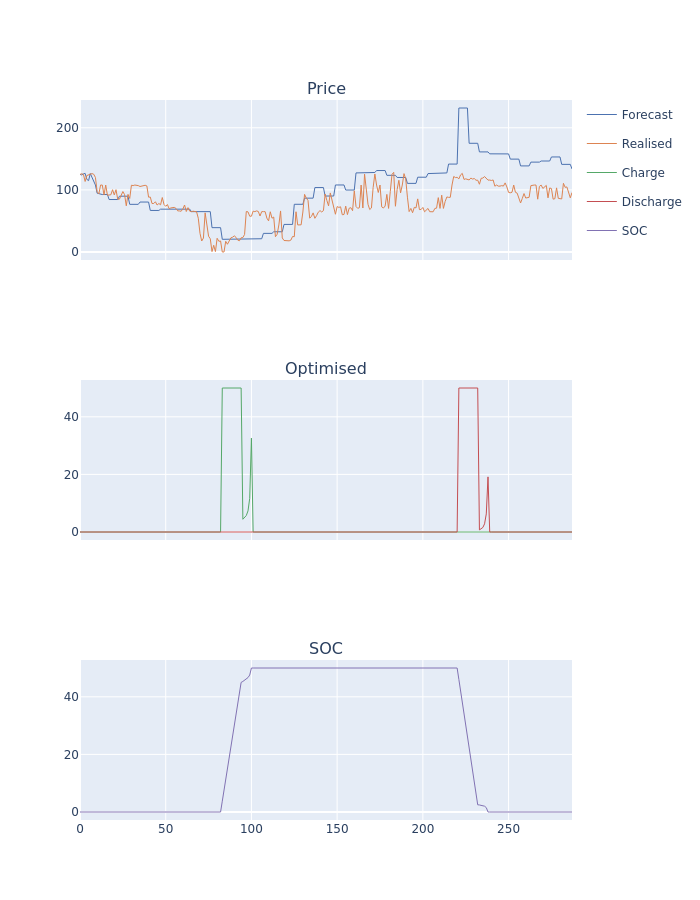

In [3]:
tsplot(
    {
        "Price": pandas.DataFrame(
            {
                "Forecast": data.forecast[0, :horizon],
                "Realised": data.realised[:horizon],
            }
        ),
        "Optimised": pandas.DataFrame(
            {
                "Charge": problem.var_dict["p_charge"].value,
                "Discharge": problem.var_dict["p_discharge"].value,
            }
        ),
        "SOC": pandas.DataFrame(
            {
                "SOC": c_soc.value,
            }
        ),
    },
    resampler=False,
).show("png")

It's worth noting, of the entire dispatch schedule that gets produced, only the first action is taken. On every 5-minute interval this optimisation is rerun, and only the first charge/discharge action is actually acted upon. It is still beneficial to look at what the optimiser produces for the full horizon as a sanity check.

# References

* [1] Python-based optimisation for BESS systems in the NEM — <https://arxiv.org/html/2510.03657v1>
* [2] Convex formulation of the BESS dispatch problem — <https://www.sciencedirect.com/science/article/pii/S2352152X24025271>
